# Colab hardware details

In [27]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


# Set paths and import all required modules

In [0]:
from pathlib import Path
import os ,sys, gc ,tarfile ,zipfile,pickle

homepath = Path('/content/drive/My Drive/EVA4/S15')
scripts  = Path('/content/drive/My Drive/EVA4/S15/scripts')
dataset  = Path('/content/drive/My Drive/EVA4/S15/dataset/pklFiles/')

os.chdir(homepath)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace

from torchvision.utils import make_grid
from torchsummary import summary
from PIL import Image
# New 
from torchvision import models

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Load dataset from pkl

In [0]:
# extract tar.gz file 
archive_name = "/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test.tar.gz"
file_name    = "data_batch_64_test"

tar = tarfile.open(archive_name, "r:gz")

tar.extract(file_name, os.path.join(dataset,file_name))

pklfile = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test'

## Transformations

In [0]:
import torchvision
import torchvision.transforms as transforms

def transformations():
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    return (transform_train, transform_test)

In [0]:
transform_train, transform_test = transformations()

# Custom dataset

In [0]:
from torch.utils.data import Dataset,IterableDataset

class customDataset(Dataset):
    '''This class is about to read custom data from pkl file'''
    def __init__(self, pklfile, root_dir, transform=None):
        """
        Args:
            pklfile (string): Path to the pkl file .
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super(customDataset).__init__()
        self.pklfile    = pklfile
        self.root_dir   = root_dir
        #self.transform  = transform
        self.transform = transform_train
        #self.dsKey      = dsKey  
        self.customData = self.unpickle(self.pklfile)
    
        self.bgfg       = self.customData['bgfg']
        self.f_bgfg     = self.customData['f_bgfg']
        [x.resize(3,224,224) for x in self.bgfg]
    
        self.f_bgfgM    = self.customData['f_bgfgM']
        self.bgfgM      = self.customData['bgfgM']
        [x.resize(224,224) for x in self.bgfgM]
        

    def __len__(self):
        return (len(self.customData['bgfg']))
        #return (len(self.customData['bgfg'])+len(self.customData['bgfgM']))


    def unpickle(self,file):
        with open(self.pklfile, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __getitem__(self, idx):
        #set_trace()
        #print(idx)
        bg_fg_img = self.transform(Image.fromarray(self.bgfg[idx].transpose(1,2,0),'RGB'))       
        mask_img = self.transform(self.bgfgM[idx])
        #depth_img = self.transfrm(Image.open(self.depths_files[index]))
        
        return {'bg_fg': bg_fg_img, 'mask': mask_img}
    '''
    def __getitemBkp__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        b_img, m_img    = self.customData['bgfg'][idx], self.customData['bgfgM'][idx]
        #set_trace()
        b_img.resize(3,224,224)
        m_img.resize(224,224)

        if self.transform is None:
            ## To PIL image
            bgfgImg,maskImg = Image.fromarray(b_img.transpose(1,2,0),'RGB') , Image.fromarray(m_img)
            sample = {'bgfg': bgfgImg, 'bgfgM': maskImg}
            
        elif self.transform:
            ## In ND array
            #b_img.resize(3,224,224)
            #m_img.resize(224,224)
            sample = {'bgfg': b_img, 'bgfgM': m_img}
            sample = self.transform(sample)
        
        return sample

    def __iter__(self):
        print('hit')
        return iter(
            (self.__getitem__(i) for i in range(
                len(self.customData[self.dsKey])
                )
            )
        )
    '''
    

# Suman practice

In [0]:
from torch.utils.data import DataLoader

trainset = customDataset(pklfile  = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test',
                    root_dir = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test',
                    )

trainloader = DataLoader(trainset, batch_size = 20, shuffle =True, pin_memory=True)


In [36]:
len(trainset)

100

In [0]:
sample = next(iter(trainloader))

In [0]:
images = sample['bg_fg']
masks = sample['mask']
#depths = sample['depth']

In [39]:
masks.shape

torch.Size([20, 1, 224, 224])

## Display few images from the dataset

In [0]:
import torchvision

def show(tensors, figsize=(10, 10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
  grid_image = grid_tensor.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image)
  plt.xticks([])
  plt.yticks([])
  plt.show()

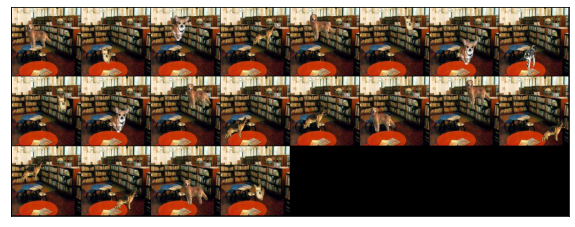

In [41]:
show(images)

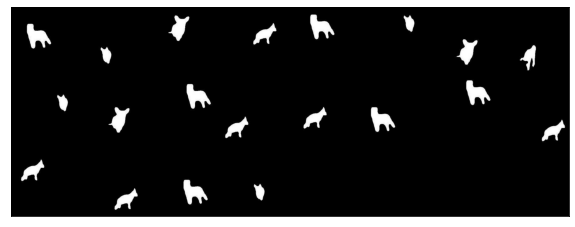

In [42]:
show(masks)

# Load model

##### U-Net


In [0]:
# Reference : https://raw.githubusercontent.com/usuyama/pytorch-unet/master/pytorch_unet.py
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, sample):
        #set_trace()
        bgfgs = sample['bg_fg']

        conv1 = self.dconv_down1(bgfgs)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        conv4d = self.dconv_down4(x)
       
        x = self.upsample(conv4)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        out1 = self.conv_last(x)
        # print('out-1: {}'.format(out1.shape))
        '''
        # Second output
        # print('conv-4-2nd : {}'.format(conv4.shape))
        x1 = self.upsample(conv4d)        
        # print('x1-2nd: {}'.format(x1.shape))
        x1 = torch.cat([x1, conv3], dim=1)
        
        x1 = self.dconv_up3(x1)
        x1 = self.upsample(x1)        
        x1 = torch.cat([x1, conv2], dim=1)       

        x1 = self.dconv_up2(x1)
        x1 = self.upsample(x1)        
        x1 = torch.cat([x1, conv1], dim=1)   
        
        x1 = self.dconv_up1(x1)
        
        out2 = self.conv_last(x)'''
        # print('out-2: {}'.format(out2.shape))
        #return out1, out2
        return out1

In [44]:
print("Building Model")
# net = S11Model()
# net = models.resnet18(pretrained=True)
net = UNet(1)
# net = CustomModel()

Building Model


In [0]:
# Display Model Summary
model = net.to(device)


In [0]:
#summary(model, input_size=(3, 224,224))

In [0]:
criterion = nn.BCEWithLogitsLoss() #SSIM( 3, reduction ="mean")
optimizer = torch.optim.SGD(model.parameters(),lr= 0.01, momentum=0.9, weight_decay=1e-5)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model,criterion,device,trainloader,optimizer,epoch):
  model.train()
  print('epoch is : {}'.format(epoch))
  pbar = tqdm(trainloader)
  for batch_idx, data in enumerate(pbar):
    data["bg_fg"] = data["bg_fg"].to(device)
    data["mask"] = data["mask"].to(device)
    #data["depth"] = data["depth"].to(device)
    #set_trace()
    optimizer.zero_grad()
    output = model(data)
    '''print('\n\n')
    print('output: {}'.format(output[0].shape))
    print('mask: {}'.format(data['mask'].shape))
    print('\n\n')'''
    loss1 = criterion(output,data["mask"])
    #loss1 = criterion(output[0],data["mask"])
    #loss2 = criterion(output[1],data["depth"])
    #loss = 2*loss1 + loss2
    loss = loss1 
    print('loss: {}'.format(loss))
    loss.backward()
    optimizer.step()
    '''print('Optimizer step completed')
    print('batch_idx: {}'.format(batch_idx))'''

    if batch_idx %50 == 0 or epoch %10 == 0:
      print('Train Epoch: {}  [{}/{}  ({:.0f}%)]\tLoss:{:.6f}'.format(
          epoch,batch_idx*len(data),len(trainloader.dataset),
          100.*batch_idx/len(trainloader),loss.item()))

      # Mask
      print("\n\nActual mask")
      show(data['mask'].detach().cpu())
      print("\n\nPredicted mask")
      show(output.detach().cpu())
      #show(output[0].detach().cpu())
    '''
      # Depth
      print("\n\nActual Depth")
      show(data['depth'].detach().cpu())
      print("\n\nPredicted Depth")
      show(output[1].detach().cpu())
    '''
      # torch.save(model.state_dict(), SAVE_PATH/f"{epoch}_{batch_idx}_{loss.item()}.pth")

In [0]:
train(model, criterion, device, trainloader, optimizer, epoch=100)

In [0]:
for epoch in range(1, 50):
    print('Training Epoch: {}'.format(epoch))
    train(model, criterion, device, trainloader, optimizer, epoch=epoch)

In [0]:
for epoch in range(51, 100):
    print('Training Epoch: {}'.format(epoch))
    train(model, criterion, device, trainloader, optimizer, epoch=epoch)